# DistillBert Classifier train and evaluate

In [99]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, load_metric 
import torch
from torch.nn import CrossEntropyLoss
import accelerate
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, AutoTokenizer
import seaborn as sns
import os
import wandb
from tqdm import tqdm

In [2]:
pd.set_option('display.max_colwidth', 1500)

In [3]:
# First, working on the DS after classificaiton by LLM

#TODO - move the file 
csv_file_path = '../data/clean_train_tweets_classified_open_ai.csv'
df = pd.read_csv(csv_file_path)
df

,clean_text,classification,error
0,@thediscovietnam coo. thanks. just dropped you a line.,1,NaN
1,"@thediscovietnam shit it ain't lettin me DM you back, what's your email?",1,NaN
2,"@thediscovietnam hey cody, quick question...can you dm me?",1,NaN
3,@smokinvinyl dang. you need anything? I got some left over meds!,0,No\n\nThe message contains a missing period at the end of the sentence.
4,"maybe i'm late in the game on this one, but this lowender vst is making my apt rumble!",1,NaN
...,...,...,...
29775,AfricaNews - KENYA: IS GREEN ENERGY POSSIBLE? - Fred Oluoch http://bit.ly/5MxYL3 [blog],1,NaN
29776,Green energy news - The Dane with green energy for Europe http://bit.ly/8CwyAg Check this out,1,NaN
29777,Green energy update Trudie Styler - http://bit.ly/5k8lso [video],1,NaN
29778,"ForestExplorers: Dams, bio-fuel plantations cannot be classified ... http://bit.ly/8teKxq [blog]",1,NaN


In [4]:
# check the df
df.sample(5)

,clean_text,classification,error
20825,"So disappointed in my teams last night. Going to be a long and sad Friday. At least the Rockies won, that's something.",1,NaN
5543,FICOD in Madrid launched awkwardly this morning with Kevin Spacey http://tinyurl.com/yhslmsn,1,NaN
24522,"It's over 6 months since my dad died, so I gotta start looking for gravestones. These things are expensive, i'll sort a goodun out though.",0,"No\n\nErrors found:\n1. ""it's"" should be capitalized as ""It's.""\n2. ""6"" should be written out as ""six.""\n3. ""gotta"" should be written as ""have to"" for formal writing.\n4. ""goodun"" should be written as ""good one.""\n5. The sentence ""i'll sort a goodun out though."" should be revised to ""I'll sort a good one out, though."""
7261,woman on the bus smells like a mix of seafood and rotting fruit. it's a very gross and unique sent.,0,"No\n\nErrors found:\n1. ""sent"" should be ""scent""\n2. Missing punctuation at the end of the sentence."
276,So much sunlight flooding union square. My atoms expand to absord it all.,0,"Errors found:\n1. ""absord"" should be ""absorb""\n\nResponse: no\n"


In [5]:
# check classification = 1
count_cells_value_1 = (df['classification'] == 1).sum()
count_cells_value_1

24277

In [6]:
# check classification = 0
count_cells_value_0 = (df['classification'] == 0).sum()
count_cells_value_0

5503

In [7]:
count_cells_value_0 + count_cells_value_1 == len(df)

True

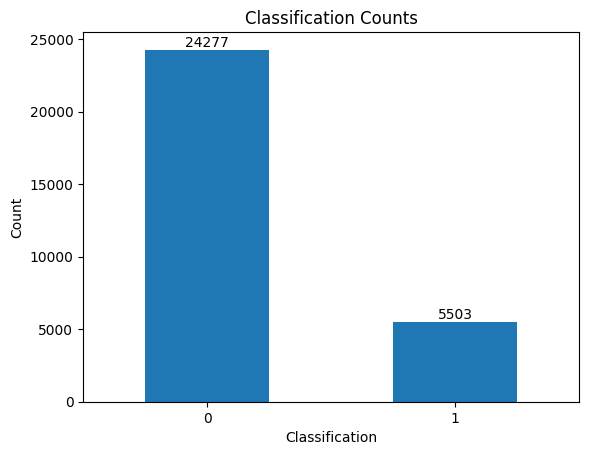

In [8]:
# Let's see the distributiion of our DS?
classification_counts = df['classification'].value_counts()
classification_counts.plot(kind='bar')
plt.title('Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0) 
for index, value in enumerate(classification_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

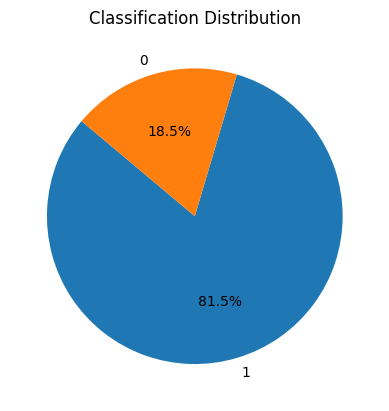

In [9]:
classification_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Classification Distribution')
plt.ylabel('')  
plt.show()

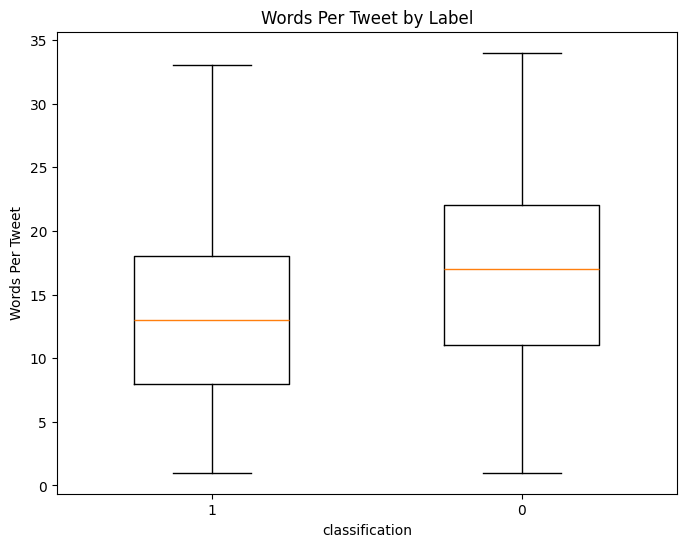

In [10]:
# Last check to see we don't have imblance in words
words_per_tweet = df['clean_text'].str.split().apply(len)
grouped_data = df.groupby('classification')['clean_text'].apply(lambda x: x.str.split().apply(len))
plt.figure(figsize=(8, 6))
labels = df['classification'].unique()
for i, label in enumerate(labels):
    data_to_plot = grouped_data.loc[label]
    plt.boxplot(data_to_plot, positions=[i], widths=0.5, showfliers=False)
plt.xticks(range(len(labels)), labels)
plt.title('Words Per Tweet by Label')
plt.xlabel('classification')
plt.ylabel('Words Per Tweet')
plt.show()

In [11]:
# inbalnce to the correct as expected, will try to work with this and if not working try balnceing technics

In [12]:
# Now let's try to train Distillber with Huggin Face and see how this works

In [13]:
# start by preparing train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['classification'], axis=1), df['classification'], test_size=0.2, random_state=42)

In [14]:
# keeping x with 'clean_text_only
X_train.drop(['error'], axis=1, inplace=True)
X_test.drop(['error'], axis=1, inplace=True)

In [15]:
len(X_train) + len(X_test) == len(df)

True

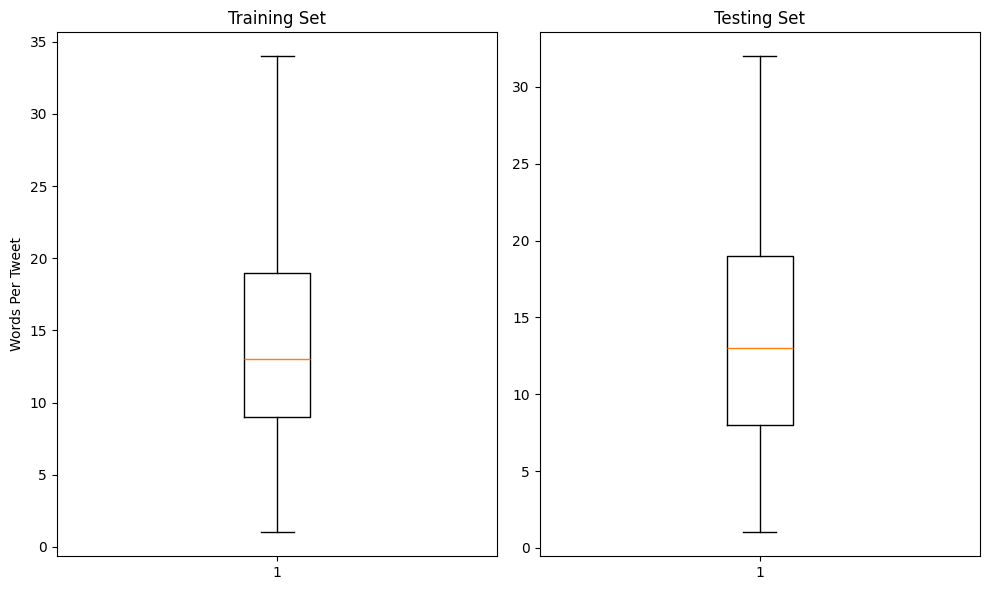

In [16]:
# Check X
words_per_tweet_train = X_train['clean_text'].str.split().apply(len)
words_per_tweet_test = X_test['clean_text'].str.split().apply(len)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.boxplot(words_per_tweet_train, showfliers=False)
plt.title('Training Set')
plt.ylabel('Words Per Tweet')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.boxplot(words_per_tweet_test, showfliers=False)
plt.title('Testing Set')
plt.tight_layout()
plt.show()

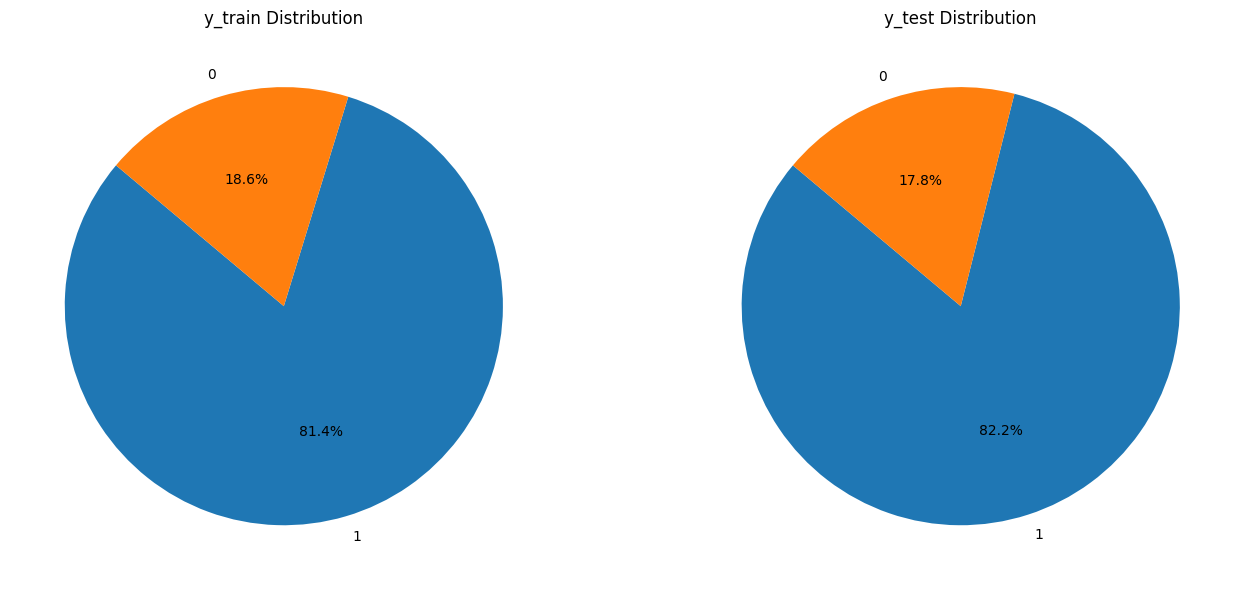

In [17]:
# check y
y_train_distribution = y_train.value_counts(normalize=True)
y_test_distribution = y_test.value_counts(normalize=True)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
y_train_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('y_train Distribution')
plt.ylabel('')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
y_test_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('y_test Distribution')
plt.ylabel('') 
plt.tight_layout()
plt.show()

In [18]:
X_train.sample(5)

,clean_text
19250,"A New Interview, My First CD Appearance, Your Girl Is Doing Her Thing: &nbs.. http://bit.ly/5o994"
10479,"More soldiers must go to Afghanistan?? If not we will ""lose the war"" and appear ""weak and impotent""??? Deja vu.....sounds bogus to me!"
8071,"RT @NoamShelef_APN: French Pres Sarkozy: Israel & Syria are willing to renew negotiations, must only now agree on the format. (Israel Radio)"
20975,How Space Shuttles Work. http://is.gd/4XU4a - almost 30 years of history here...
28935,"@BillyTheBrime I'm so glad someone agrees that I've got a right to be mad, boo."


In [19]:
y_train.sample(5)

27011    1
6607     1
29438    0
25427    1
12212    1
Name: classification, dtype: int64

In [20]:
X_test.sample(5)

,clean_text
14494,@alizasherman Thank you Big Alaska (formerly known as my buddy across Broad Street) #read4change
11212,"@xoxo_GossipGuy Where are you from, I'm from Scotland and it's so so so cold :("
23489,"@_clevername you, you, and you lol This may take a while though, 19K followers I have a lot to review"
7510,@veronicaludwig i know! 1.5b euro each. U owe me :)
10038,LAST CHANCE: RT and/or follow to win kid & mom-approved Kat in the City placemat + Matte Stephenson Monster mat http://ow.ly/BxDG #contest


In [21]:
y_test.sample(5)

2435     1
23725    1
20061    0
8867     1
11293    1
Name: classification, dtype: int64

In [22]:
# Tokenize 
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [23]:
# Prepare the dataset
train_df = pd.DataFrame({
    'text': X_train['clean_text'],  
    'labels': y_train 
})

In [24]:
# Convert the DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
train_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 23824
})

In [25]:
train_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 23824
})

In [26]:
# Tweets are limited to 280, 350 is max with splits 

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=350)

In [27]:
# Tokenize the dataset
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/23824 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 23824
})

In [28]:
# Looking on random one
tokenized_datasets[88].get('text')

'RT @donovanpalmer: RT @espn: Tiger Woods injured in early-morning car crash - http://tinyurl.com/yavxgyy'

In [29]:
input_ids_88 = tokenized_datasets[88]['input_ids']
print("First 5 elements:", input_ids_88[:5], "Last 5 elements:", input_ids_88[-5:], "Length = ", len(input_ids_88))


First 5 elements: [101, 19387, 1030, 12729, 12952] Last 5 elements: [0, 0, 0, 0, 0] Length =  350


In [30]:
# Load the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # I have 16GB GPU, adapting
    num_train_epochs=3,
    weight_decay=0.01,
)

In [32]:
# sanity - train 1000 and see where the wind blow?
sanity_tokenized_datasets = tokenized_datasets.select(range(1000))
sanity_tokenized_datasets

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [33]:
# Initialize the Trainer - sanity
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sanity_tokenized_datasets, # TODO: replace
)

/home/user/miniconda3/envs/x_grammar_spelling/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [34]:
# Train the model sanity (about a 2 minuites on 3070 16GB - laptop)
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nirkon. Use `wandb login --relogin` to force relogin


  0%|          | 0/96 [00:00<?, ?it/s]

{'train_runtime': 152.4876, 'train_samples_per_second': 19.674, 'train_steps_per_second': 0.63, 'train_loss': 0.4194614092508952, 'epoch': 3.0}


TrainOutput(global_step=96, training_loss=0.4194614092508952, metrics={'train_runtime': 152.4876, 'train_samples_per_second': 19.674, 'train_steps_per_second': 0.63, 'train_loss': 0.4194614092508952, 'epoch': 3.0})

In [35]:
# let's try on 1
text_1 = df['clean_text'].iloc[0]
text_1

'@thediscovietnam coo.  thanks. just dropped you a line.'

In [36]:
y_test.iloc[0]

1

In [37]:
inputs_1 = tokenizer(text_1, padding=True, truncation=True, return_tensors="pt")
inputs_1

{'input_ids': tensor([[  101,  1030,  1996, 10521,  3597, 13469,  2102, 13129,  2522,  2080,
          1012,  4283,  1012,  2074,  3333,  2017,  1037,  2240,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [38]:
# predict on first 
model.eval()  # Set the model to evaluation mode
if torch.cuda.is_available():
    model = model.cuda()
    inputs = {k: v.cuda() for k, v in inputs_1.items()}
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_class_id = logits.argmax(-1).item()
predicted_class_id

1

In [39]:
# Tokenize the entire test dataset
test_encodings = tokenizer(X_test['clean_text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=350)
test_encodings

{'input_ids': tensor([[  101,  1030, 21766,  ...,     0,     0,     0],
        [  101,  4638,  2041,  ...,     0,     0,     0],
        [  101,  1030, 12270,  ...,     0,     0,     0],
        ...,
        [  101,  1030, 29294,  ...,     0,     0,     0],
        [  101,  5035, 10556,  ...,     0,     0,     0],
        [  101,  1030,  8915,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [40]:
# Create a dataset from the tensor encodings
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_dataset

In [101]:
# Create a DataLoader
test_data_loader = DataLoader(test_dataset, batch_size=32)

In [102]:
# predict on full test
def predict_with_model(model, test_data_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    for batch in tqdm(test_data_loader):
        # Move batch to the same device as model
        batch = tuple(item.to(model.device) for item in batch)
        input_ids, attention_mask = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
    return predictions

In [43]:
predictions = predict_with_model(model, test_data_loader)
predictions[0:5]

[1, 1, 1, 1, 1]

In [44]:
# let's see the reports
def print_statistics(true_labels, model_predictions):
    
    # Calculate F1 score
    f1 = f1_score(true_labels, model_predictions, average='weighted')
    print(f"F1 score: {f1}")

    # Generate classification report
    report = classification_report(true_labels, model_predictions)
    print(report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, model_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

F1 score: 0.8078129102668905
              precision    recall  f1-score   support

           0       0.67      0.23      0.34      1062
           1       0.85      0.98      0.91      4894

    accuracy                           0.84      5956
   macro avg       0.76      0.60      0.62      5956
weighted avg       0.82      0.84      0.81      5956



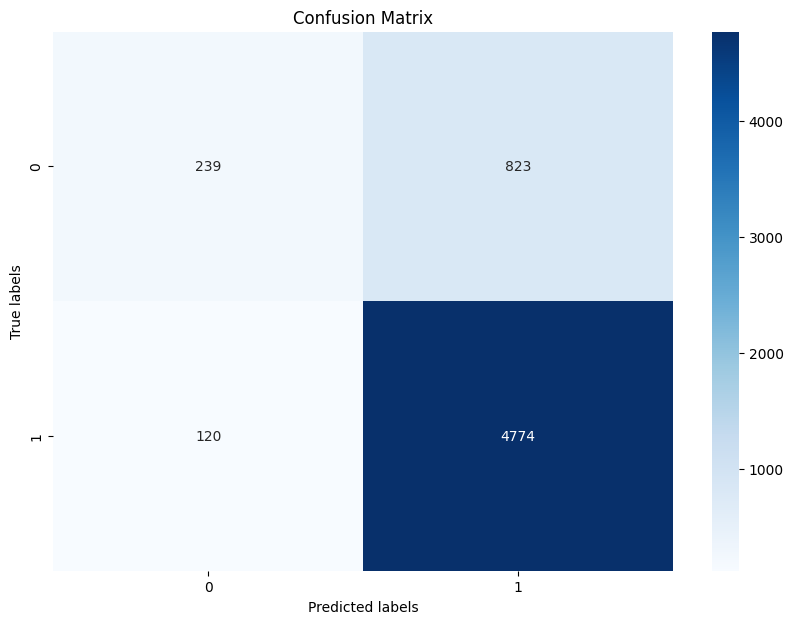

In [45]:
# Let's see reports
print_statistics(y_test, predictions)

In [46]:
#### only 1k and impressive ####

In [47]:
### IMPORTANT - test were done here, removed to siplify:
#   1 - Simple full train - withut class weights, 5% less on "0" calls than with class wieght.
#   2 - Oversampeling minority calls ("0") - each minority row was duplicated, 3% class on "0" calls than with class wieght.
#   *. Seems like class weight is working here, see below

In [48]:
# Handle with class weights

In [49]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor

tensor([2.6823, 0.6146])

In [50]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.01
)

In [51]:
# Since HF Trainer not supporting compute_loss, we overide it
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=torch.tensor([2.7488, 0.6112]).to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        print(loss) # workaround - nothing works on this hf.....
        return (loss, outputs) if return_outputs else loss

In [52]:
class CustomCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model, **kwargs):
        print(f"Epoc {state}") # workaround - nothing works on this hf.....
        output_dir = os.path.join(args.output_dir, f"epoch_{state.epoch}")
        model.save_pretrained(output_dir)


In [53]:
# reset the model to start
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    callbacks=[CustomCallback]
)

/home/user/miniconda3/envs/x_grammar_spelling/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [55]:
# Train the model full - custom loss
trainer.train()

  0%|          | 0/4470 [00:00<?, ?it/s]

tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6919, device='cuda:0', grad_fn=

TrainOutput(global_step=4470, training_loss=0.25014220030782475, metrics={'train_runtime': 5959.9593, 'train_samples_per_second': 23.984, 'train_steps_per_second': 0.75, 'train_loss': 0.25014220030782475, 'epoch': 6.0})

In [63]:
# New Y predictions
predictions = predict_with_model(model, test_data_loader)
predictions[0:5]

[1, 1, 1, 1, 0]

F1 score: 0.8581354419635714
              precision    recall  f1-score   support

           0       0.67      0.49      0.57      1062
           1       0.90      0.95      0.92      4894

    accuracy                           0.87      5956
   macro avg       0.78      0.72      0.74      5956
weighted avg       0.86      0.87      0.86      5956



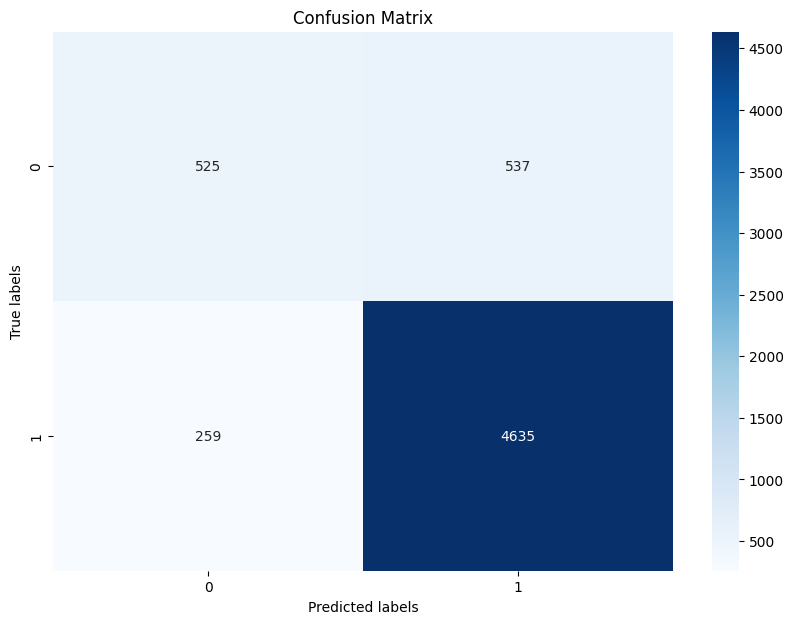

In [64]:
# Reports ?
print_statistics(y_test, predictions)

In [65]:
# So far (30k ds, the best)
model.save_pretrained("../model")
tokenizer.save_pretrained("../model")

('../model/tokenizer_config.json',
 '../model/special_tokens_map.json',
 '../model/vocab.txt',
 '../model/added_tokens.json',
 '../model/tokenizer.json')

In [66]:
# goind to resample the minory class to double it's size
train_df

,text,labels
27791,So incredibly zapped of energy.,1
1383,Why did the football team go the bank.,0
26539,I'm in a really good mood. it's kinda weird. I feel my life improving. well insomnia. so talk talk talk all night.,0
2441,RT @paperfans: I have never seen one of our cards get so many 5 stars: http://bit.ly/2gJfeS I'm happy and pleasantly surprised,1
21878,@peeeej Wow - you are going with relaxation 1st with the cruise and then finishing up with Disney World! Sounds like fun!,1
...,...,...
21575,Okay... turning in early (what a novel idea!) Got an appt w/trainer at 5:00 a.m.... can't wait (she said sarcastically),1
5390,This discourse on time by Matt Jones needs to be read by more people: http://bit.ly/14Y4zl,1
860,The Emancipation of Big G: Anwan Glover http://bit.ly/mDKr6 (archive),1
15795,"not very talkative...I mean...kinda depressed, and really tired.",1


In [67]:
# Create a question answer csv
test_result_df = X_test.copy()
test_result_df

,clean_text
13494,@RUunknown what about Randy Macho Man Savage?
28441,Check out Sprint's 4G Rollout Tomorrow with Social Media Club Dallas and @cndavis .. It's gonna be a party! #smcdallas http://bit.ly/10Ca83
11247,@DarrenMcgown haha yeah I saw your status forgot to actually ask how was it? You know i should really apply to work there!!! i love #dominos
28176,Meet Offerpal at the #engage expo: Anu speaks on 2 panels: http://ow.ly/qu58
26778,RT @thatchickleeann its getting to be about that time to get ready for the nite...let the fesitivities begin!! << LETS DO IT!
...,...
6596,"In preparation for the Twoffice move, @gregpass has channeled his inner hobo. http://yfrog.com/0kam2ij"
6250,another night.. ALONE!! UGH!!
8889,"@GeekyChic Would make sense for them to have access to a steady stream of original content, but isn't their reach waning? Maybe FB should."
15143,kim kardashian | red cups | twilight saga | time warner | nyc mayor | voted selena gomez | demi lovato | http://happn.in/la/04nov09-08am/


In [68]:
test_result_df['labels'] = y_test
test_result_df['predictions'] = predictions
test_result_df

,clean_text,labels,predictions
13494,@RUunknown what about Randy Macho Man Savage?,1,1
28441,Check out Sprint's 4G Rollout Tomorrow with Social Media Club Dallas and @cndavis .. It's gonna be a party! #smcdallas http://bit.ly/10Ca83,1,1
11247,@DarrenMcgown haha yeah I saw your status forgot to actually ask how was it? You know i should really apply to work there!!! i love #dominos,0,1
28176,Meet Offerpal at the #engage expo: Anu speaks on 2 panels: http://ow.ly/qu58,1,1
26778,RT @thatchickleeann its getting to be about that time to get ready for the nite...let the fesitivities begin!! << LETS DO IT!,0,0
...,...,...,...
6596,"In preparation for the Twoffice move, @gregpass has channeled his inner hobo. http://yfrog.com/0kam2ij",1,1
6250,another night.. ALONE!! UGH!!,1,1
8889,"@GeekyChic Would make sense for them to have access to a steady stream of original content, but isn't their reach waning? Maybe FB should.",1,1
15143,kim kardashian | red cups | twilight saga | time warner | nyc mayor | voted selena gomez | demi lovato | http://happn.in/la/04nov09-08am/,1,1


In [70]:
test_result_df = pd.merge(test_result_df, df[['clean_text', 'error']], on='clean_text', how='left')

In [71]:
test_result_df.sample(30)

,clean_text,labels,predictions,error
1344,U.S. FarmVille players outnumber actual farmers 60 to 1. http://ff.im/-aKF9D,1,1,NaN
625,http://twitpic.com/p0ru8 -,0,0,This message does not contain any spelling or grammar errors.
1433,Working on a family calendar 4 #Christmas. Got a bunch last year and they were a huge hit! LOVE this Company! http://bit.ly/QzOpm,1,1,NaN
2227,What's a super-cheap place I can host an SMTP server? Don't say Amazon EC2 (must support reverse-DNS for reliable email sending),0,1,"No\n\nErrors found:\n1. ""What's"" should be written as ""What is"" for formal writing.\n2. ""super-cheap"" should be hyphenated as ""super cheap.""\n3. ""Don't"" should be written as ""do not"" for formal writing.\n4. ""EC2"" should be written as ""EC2,"" as it is an acronym.\n5. ""reverse-DNS"" should be hyphenated as ""reverse DNS."""
1544,Starwatch consumer | Mortgage rates reach a record low http://bit.ly/6dJL2Y,1,1,NaN
4756,Know thyself. Plato,1,1,NaN
2245,@EA_APOC Hey! Congratulations from the entire Icrontic crew! Woot!,1,1,NaN
1652,anyone trying to improve that situation is someone we both want to work with. it needs to be addressed.,1,1,NaN
1374,"@ohaijoe Well he's president now - an elected official - change/hope were slogans from the start, but there's still promises #read4change",1,1,NaN
5916,Halle Berry Doesn't Have a Bun in the Oven http://bit.ly/UtBhq,1,1,NaN


In [73]:
# how many 1
ones = test_result_df[test_result_df['labels'] == 1].shape[0]
ones

4894

In [74]:
# how many 0
zeors = test_result_df[test_result_df['labels'] == 0].shape[0]
zeors

1063

In [75]:
to_remove = ones - zeors
to_remove

3831

In [76]:
balanced_test_df = test_result_df[test_result_df['labels'] == 0] 
balanced_test_df

,clean_text,labels,predictions,error
2,@DarrenMcgown haha yeah I saw your status forgot to actually ask how was it? You know i should really apply to work there!!! i love #dominos,0,1,"No, there are a few errors in the message:\n1. ""forgot"" should be ""forget"" to match the past tense of ""saw.""\n2. ""how was it?"" should be ""how it was?"" to form a complete question.\n3. ""i"" should be capitalized as ""I.""\n4. ""should really apply"" should be ""should really apply"" for correct verb form.\n5. ""love"" should be ""love"" to match the subject ""I.""\nOverall, the corrected message would be: ""@DarrenMcgown haha yeah I saw your status, forget to actually ask how it was? You know I should really apply to work there!!! I love #dominos."""
4,RT @thatchickleeann its getting to be about that time to get ready for the nite...let the fesitivities begin!! << LETS DO IT!,0,0,"No\n\nErrors:\n1. ""its"" should be ""it's""\n2. ""nite"" should be ""night""\n3. ""fesitivities"" should be ""festivities"""
10,@Soh_Authentik when you taking over the world with me??,0,0,"No\n\nError: ""taking"" should be ""take"""
17,Goodnight twiches. *selling book in my sleep* you *buying book in your sleep*,0,0,"No\n\nErrors found:\n1. ""twiches"" should be ""tweeps""\n2. The sentence ""you *buying book in your sleep*"" should be ""you're buying a book in your sleep."""
30,Fine even not one,0,1,"""No, errors found."" \n\nThe message should be: ""Fine, even not one."" The comma is needed after ""Fine"" to separate the introductory word from the rest of the sentence."
...,...,...,...,...
5923,@PamSlaterPrice Thank you for the Tweet--your proactivity regarding this serious issue is most apprecfiated!,0,0,"No, there is a spelling error in ""apprecfiated."" It should be ""appreciated."""
5928,@chuckpettke yep. I've already preordered it from B&N. cant wait.,0,1,"No\n\nErrors:\n1. ""cant"" should be ""can't"" (contraction of ""cannot"")."
5929,The advance PR has been organized and seamless. United pics in the mag. RT @david_schwab Power of twitter & smart from ESPN Body Issue,0,0,"No, there are a few errors in the message:\n1. ""United pics in the mag."" should be ""United pics in the mag.""\n2. ""smart from ESPN Body Issue"" should be ""smart move from ESPN Body Issue.""\n3. The message lacks proper punctuation at the end. \n\nTherefore, the corrected message is: ""The advance PR has been organized and seamless. United pics in the mag. RT @david_schwab Power of Twitter & smart move from ESPN Body Issue."""
5948,@Madison_Hilde client heads back 2 nyc 2nite. Who should we contact 2 see some of ur listings in malibu 2day?,0,0,"No, errors found:\n1. ""2nite"" should be written as ""tonight.""\n2. ""2"" should be written as ""to.""\n3. ""2day"" should be written as ""today."" \n\nTherefore, the corrected tweet is: \n@Madison_Hilde client heads back to NYC tonight. Who should we contact to see some of your listings in Malibu today?"


In [77]:
ones_test_sampled = test_result_df[test_result_df['labels'] == 1].sample(n=zeors, random_state=42)
ones_test_sampled

,clean_text,labels,predictions,error
183,"The more we learn about dolphins, the more we must admit they are our counterparts. Must see documentary: ""The Cove"" http://tiny.cc/bKxMn",1,1,NaN
96,Famous Birthday- Lisa Ling is 35 years old today. Great to hear that she and her sister were reunited last month.,1,1,NaN
5639,"@unthinkingly If you don't like /cc, you could try /for: http://microsyntax.pbworks.com/for #slashtags",1,1,NaN
4676,Housing Starts Edge Up in September: http://bit.ly/37n2Ju,1,1,NaN
5584,Is Be-a-magpie A Scam? | Farticle.net http://tinyurl.com/yeggnew,1,1,NaN
...,...,...,...,...
870,amazing opening to barneson place! 3 out of the 10 already sold! tomorrow is the official opening 11am to 5pm.,1,1,NaN
4748,More faves 4 #FollowFriday: @aquaexpeditions @FSWestlake @jorgecollazo @WLosAngeles @lululemon @RitzCarltonPR @luckychica @CaitlinJMurphy,1,1,NaN
5264,@Hucitter awww how sweet of you,1,1,NaN
4863,@LamontBender :-),1,1,NaN


In [78]:
balanced_test_df = pd.concat([balanced_test_df, ones_test_sampled], ignore_index=True)
balanced_test_df

,clean_text,labels,predictions,error
0,@DarrenMcgown haha yeah I saw your status forgot to actually ask how was it? You know i should really apply to work there!!! i love #dominos,0,1,"No, there are a few errors in the message:\n1. ""forgot"" should be ""forget"" to match the past tense of ""saw.""\n2. ""how was it?"" should be ""how it was?"" to form a complete question.\n3. ""i"" should be capitalized as ""I.""\n4. ""should really apply"" should be ""should really apply"" for correct verb form.\n5. ""love"" should be ""love"" to match the subject ""I.""\nOverall, the corrected message would be: ""@DarrenMcgown haha yeah I saw your status, forget to actually ask how it was? You know I should really apply to work there!!! I love #dominos."""
1,RT @thatchickleeann its getting to be about that time to get ready for the nite...let the fesitivities begin!! << LETS DO IT!,0,0,"No\n\nErrors:\n1. ""its"" should be ""it's""\n2. ""nite"" should be ""night""\n3. ""fesitivities"" should be ""festivities"""
2,@Soh_Authentik when you taking over the world with me??,0,0,"No\n\nError: ""taking"" should be ""take"""
3,Goodnight twiches. *selling book in my sleep* you *buying book in your sleep*,0,0,"No\n\nErrors found:\n1. ""twiches"" should be ""tweeps""\n2. The sentence ""you *buying book in your sleep*"" should be ""you're buying a book in your sleep."""
4,Fine even not one,0,1,"""No, errors found."" \n\nThe message should be: ""Fine, even not one."" The comma is needed after ""Fine"" to separate the introductory word from the rest of the sentence."
...,...,...,...,...
2121,amazing opening to barneson place! 3 out of the 10 already sold! tomorrow is the official opening 11am to 5pm.,1,1,NaN
2122,More faves 4 #FollowFriday: @aquaexpeditions @FSWestlake @jorgecollazo @WLosAngeles @lululemon @RitzCarltonPR @luckychica @CaitlinJMurphy,1,1,NaN
2123,@Hucitter awww how sweet of you,1,1,NaN
2124,@LamontBender :-),1,1,NaN


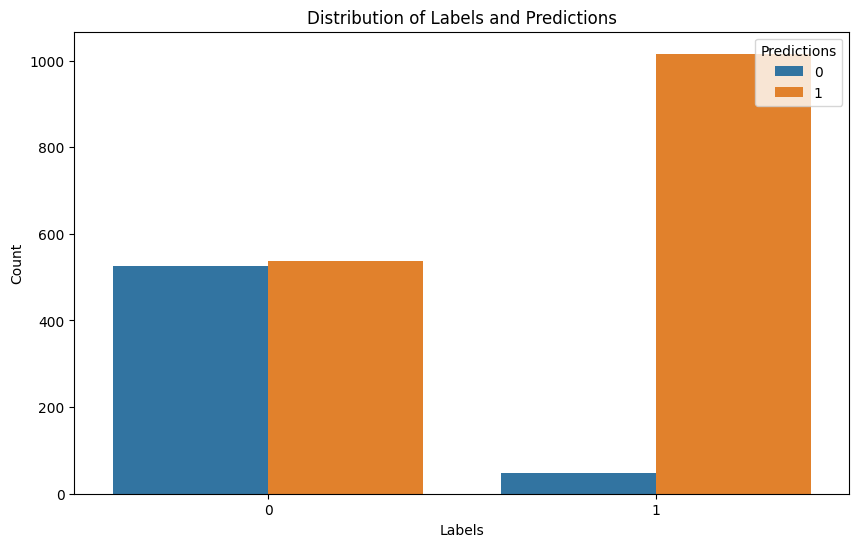

In [79]:
# Plot the balanced test df
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', hue='predictions', data=balanced_test_df)
plt.title('Distribution of Labels and Predictions')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend(title='Predictions', loc='upper right')
plt.show()

In [80]:
# Save it as csv to see on the ui 
balanced_test_df.to_csv("../static/texts/balanced_test_df.csv")

wandb: Network error (ReadTimeout), entering retry loop.


In [ ]:
# Try few models, no validation is a real problem when choosing model 

100%|██████████| 187/187 [00:09<00:00, 20.62it/s]


F1 score: 0.8581354419635714
              precision    recall  f1-score   support

           0       0.67      0.49      0.57      1062
           1       0.90      0.95      0.92      4894

    accuracy                           0.87      5956
   macro avg       0.78      0.72      0.74      5956
weighted avg       0.86      0.87      0.86      5956



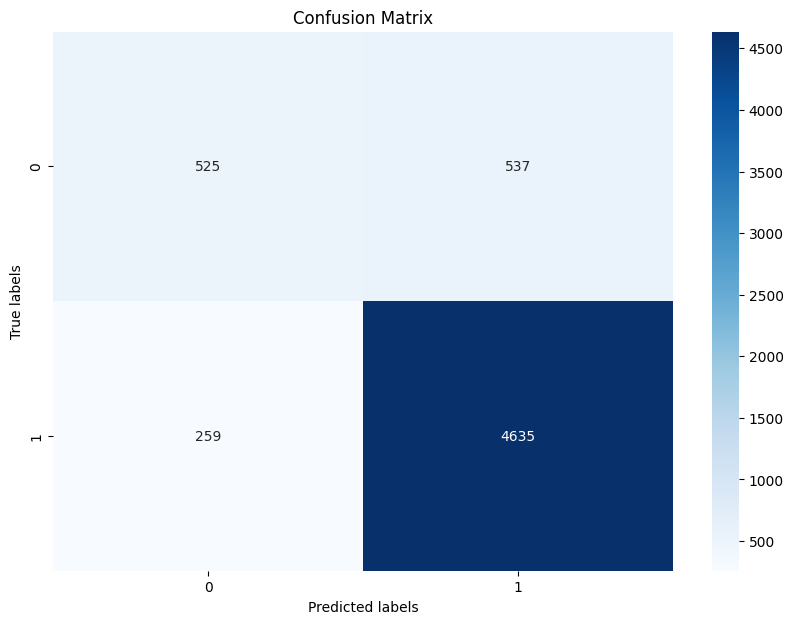

In [112]:
# epoch = 6
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_6.0/'
tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

100%|██████████| 187/187 [00:09<00:00, 20.49it/s]


F1 score: 0.8592827296334666
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1062
           1       0.90      0.94      0.92      4894

    accuracy                           0.86      5956
   macro avg       0.77      0.74      0.75      5956
weighted avg       0.86      0.86      0.86      5956



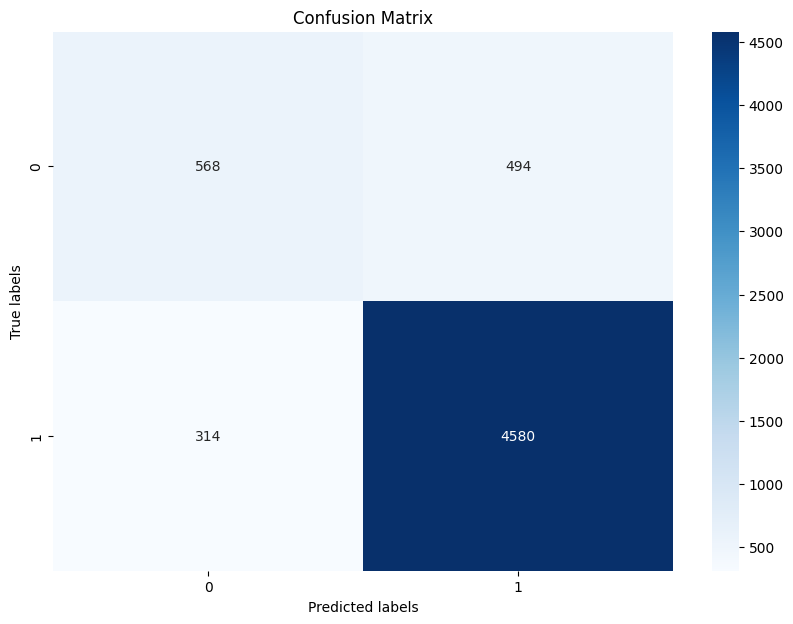

In [113]:
# epoch = 5
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_5.0/'
tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

100%|██████████| 187/187 [00:09<00:00, 20.41it/s]


F1 score: 0.860949371260307
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      1062
           1       0.91      0.92      0.92      4894

    accuracy                           0.86      5956
   macro avg       0.77      0.75      0.76      5956
weighted avg       0.86      0.86      0.86      5956



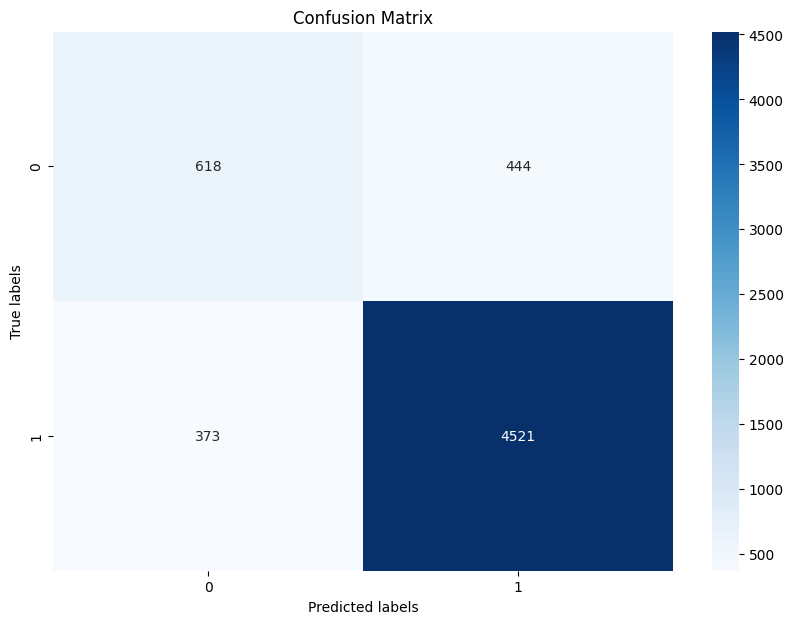

In [114]:
# epoch = 4
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_4.0/'
tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

100%|██████████| 187/187 [00:09<00:00, 20.46it/s]


F1 score: 0.8544208179600932
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1062
           1       0.92      0.90      0.91      4894

    accuracy                           0.85      5956
   macro avg       0.75      0.76      0.76      5956
weighted avg       0.86      0.85      0.85      5956



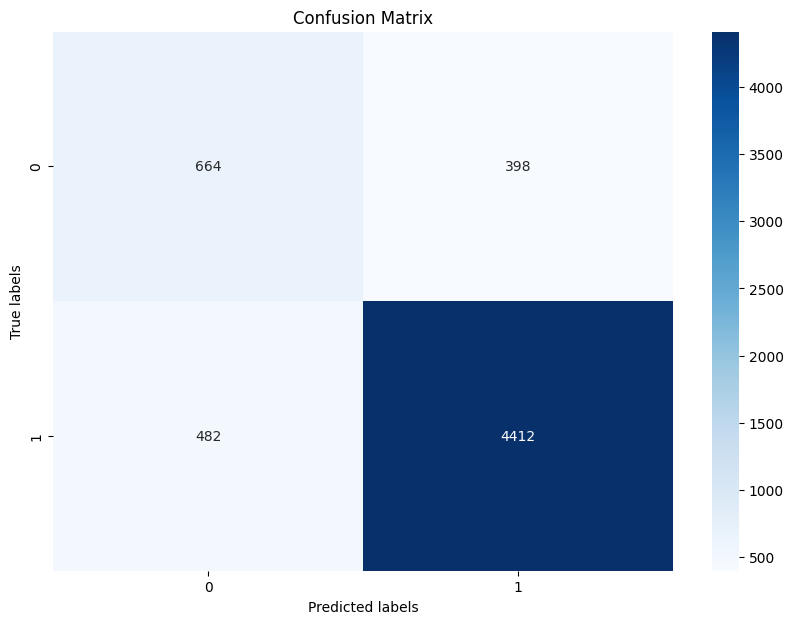

In [115]:
# epoch = 3
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_3.0/'
tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

100%|██████████| 187/187 [00:09<00:00, 20.60it/s]


F1 score: 0.8588594676663028
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      1062
           1       0.92      0.91      0.91      4894

    accuracy                           0.86      5956
   macro avg       0.76      0.77      0.76      5956
weighted avg       0.86      0.86      0.86      5956



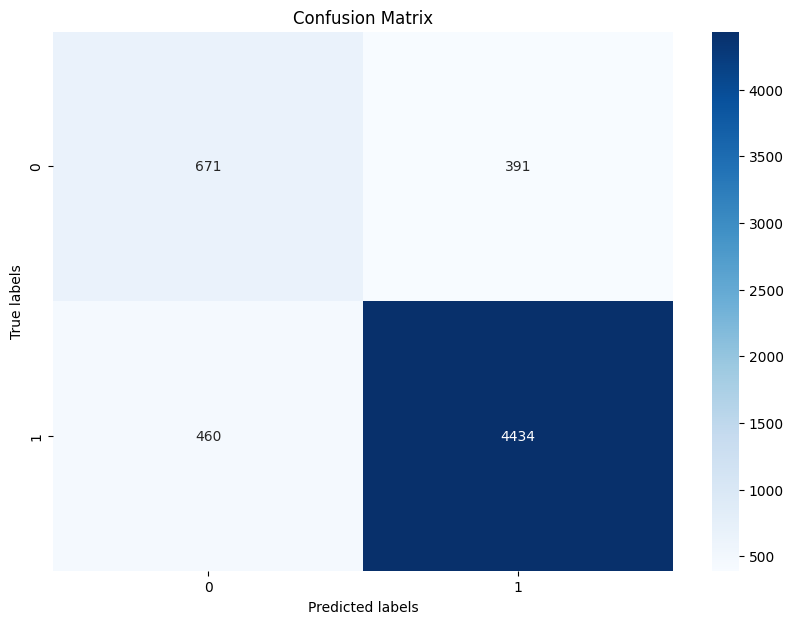

In [116]:
# epoch = 2
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_2.0/'
tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

100%|██████████| 187/187 [00:09<00:00, 20.73it/s]


F1 score: 0.8094766232041383
              precision    recall  f1-score   support

           0       0.45      0.78      0.57      1062
           1       0.94      0.79      0.86      4894

    accuracy                           0.79      5956
   macro avg       0.70      0.79      0.72      5956
weighted avg       0.85      0.79      0.81      5956



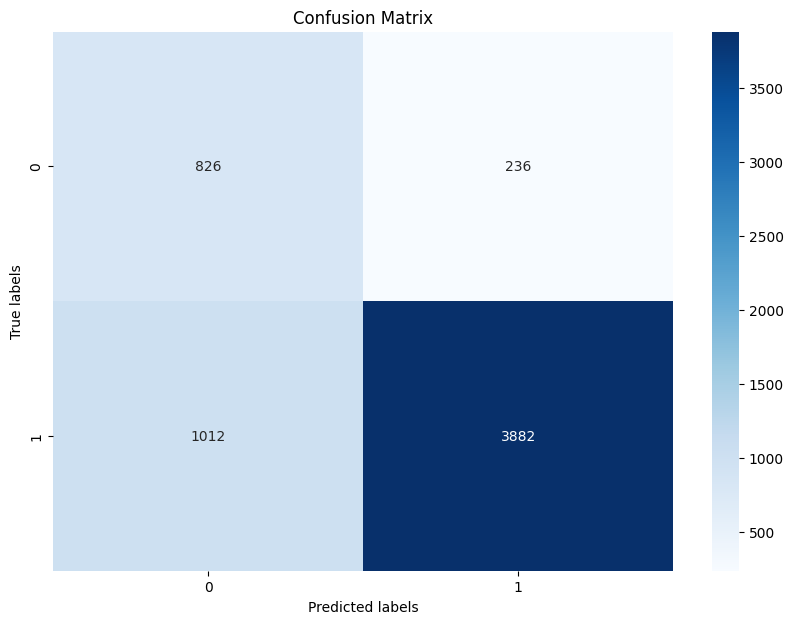

In [118]:
# epoch = 1
model_directory = '/home/user/IdeaProjects/x_grammar_spelling/classification_by_open_ai/results/epoch_1.0/'
# tokenizer = DistilBertTokenizer.from_pretrained(model_directory)
model = DistilBertForSequenceClassification.from_pretrained(model_directory)
# Move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

In [120]:
# let's try 2 epocs on a balanced ds
df_label_0 = train_df[train_df['labels'] == 0]
df_label_1 = train_df[train_df['labels'] == 1]
min_count = min(len(df_label_0), len(df_label_1))
if len(df_label_0) > len(df_label_1):
    df_label_0 = df_label_0.sample(n=min_count, random_state=42)  
else:
    df_label_1 = df_label_1.sample(n=min_count, random_state=42)
balanced_df = pd.concat([df_label_0, df_label_1])
balanced_df

,text,labels
1383,Why did the football team go the bank.,0
26539,I'm in a really good mood. it's kinda weird. I feel my life improving. well insomnia. so talk talk talk all night.,0
14569,Getting ready to beat the pavement looking for a place! But on the up side...Happy 420!!!,0
11216,I think she is stupid going back to justin- that Aussie guy is hot,0
12011,"Lovin' Lakin LOVES Tom Lenk. He is a genius of the mind. Gusthausen, frou meow meow.",0
...,...,...
26068,"Kids, Antidepressants, and Suicide Risk: A Review of Commercial Bias http://bit.ly/82jF7L",1
26918,Who is going to win the NBA championship this year? $500 if you vote now - I did it - do it! www.nbachampionshipvote.com,1
11025,"Up until today, I was worried climate change had made summer too cold. Now I am just hot.",1
14881,@searchcircus what do you think?,1


In [122]:
len(balanced_df[train_df['labels'] == 0]) == len(balanced_df[train_df['labels'] == 1])

/tmp/ipykernel_4035572/247675889.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(balanced_df[train_df['labels'] == 0]) == len(balanced_df[train_df['labels'] == 1])
/tmp/ipykernel_4035572/247675889.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(balanced_df[train_df['labels'] == 0]) == len(balanced_df[train_df['labels'] == 1])


True

In [124]:
# Convert the DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(balanced_df)
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/8882 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 8882
})

In [135]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # I have 16GB GPU, adapting
    num_train_epochs=3,
    weight_decay=0.01,
)

In [136]:
# reset the model to start
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets, 
)

/home/user/miniconda3/envs/x_grammar_spelling/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [138]:
trainer.train()

  0%|          | 0/834 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.4986, 'grad_norm': 5.751518249511719, 'learning_rate': 8.00959232613909e-06, 'epoch': 1.8}
{'train_runtime': 1093.5539, 'train_samples_per_second': 24.366, 'train_steps_per_second': 0.763, 'train_loss': 0.444610220636967, 'epoch': 3.0}


TrainOutput(global_step=834, training_loss=0.444610220636967, metrics={'train_runtime': 1093.5539, 'train_samples_per_second': 24.366, 'train_steps_per_second': 0.763, 'train_loss': 0.444610220636967, 'epoch': 3.0})

100%|██████████| 187/187 [00:09<00:00, 20.10it/s]


F1 score: 0.8293333711883422
              precision    recall  f1-score   support

           0       0.49      0.73      0.59      1062
           1       0.93      0.83      0.88      4894

    accuracy                           0.82      5956
   macro avg       0.71      0.78      0.73      5956
weighted avg       0.86      0.82      0.83      5956



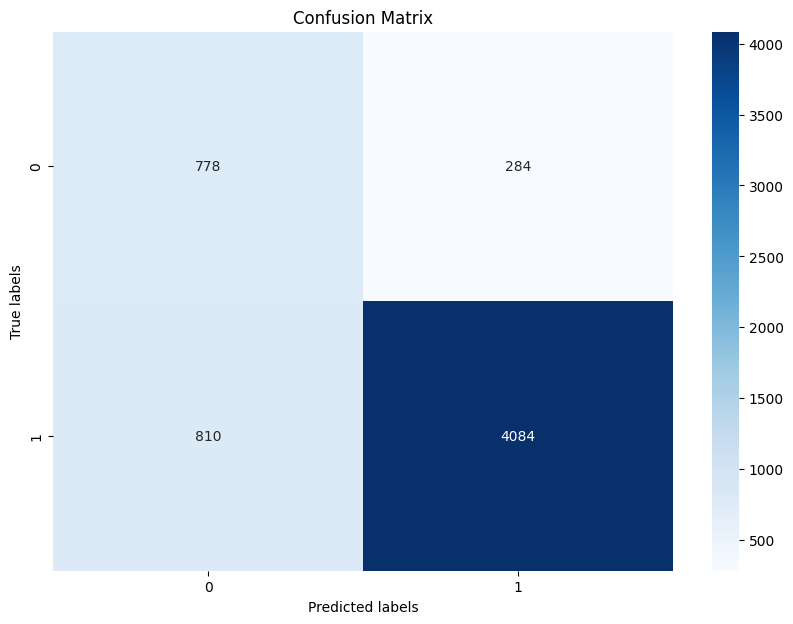

In [139]:
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)

In [140]:
# interesting
model.save_pretrained("../model")
tokenizer.save_pretrained("../model")

('../model/tokenizer_config.json',
 '../model/special_tokens_map.json',
 '../model/vocab.txt',
 '../model/added_tokens.json')

In [141]:
# balanced df was a disaster - let's try x3 on the ones  
df_label_0 = train_df[train_df['labels'] == 0]
df_label_1 = train_df[train_df['labels'] == 1]
min_count = min(len(df_label_0), len(df_label_1))
if len(df_label_0) > len(df_label_1):
    df_label_0 = df_label_0.sample(n=min_count, random_state=42)  
else:
    df_label_1 = df_label_1.sample(n=min_count * 3, random_state=42)
balanced_df = pd.concat([df_label_0, df_label_1])
balanced_df

,text,labels
1383,Why did the football team go the bank.,0
26539,I'm in a really good mood. it's kinda weird. I feel my life improving. well insomnia. so talk talk talk all night.,0
14569,Getting ready to beat the pavement looking for a place! But on the up side...Happy 420!!!,0
11216,I think she is stupid going back to justin- that Aussie guy is hot,0
12011,"Lovin' Lakin LOVES Tom Lenk. He is a genius of the mind. Gusthausen, frou meow meow.",0
...,...,...
14690,RT @AtlanticRecords: Head over to http://bit.ly/IrXpI to check out @estelledarlings new site! http://bit.ly/4BVWMY,1
18116,"LK: Mostly Cloudy with Haze and 60 F at Detroit Metropolitan Wayne County Airport, MI Winds are Southeast at 4.6 MPH (4 http://s1z.us/al.htm",1
29464,"Writing a 2nd verse to a song I wrote like 4 months ago? Lol, told y'all I can't stand forcin a record. It's flowin now. :-)",1
20981,Location Is The Missing Link Between Social Networks And The Real World. http://bit.ly/1ox76D - which side are you on?,1


In [142]:
# Convert the DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(balanced_df)
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/17764 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 17764
})

In [143]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # I have 16GB GPU, adapting
    num_train_epochs=3,
    weight_decay=0.01,
)

In [144]:
# reset the model to start
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [145]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets, 
)

/home/user/miniconda3/envs/x_grammar_spelling/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [146]:
trainer.train()

  0%|          | 0/1668 [00:00<?, ?it/s]

Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.4404, 'grad_norm': 4.372876167297363, 'learning_rate': 1.4004796163069546e-05, 'epoch': 0.9}


Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.3309, 'grad_norm': 4.943357467651367, 'learning_rate': 8.00959232613909e-06, 'epoch': 1.8}


Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.2617, 'grad_norm': 11.787891387939453, 'learning_rate': 2.0143884892086333e-06, 'epoch': 2.7}
{'train_runtime': 2215.1714, 'train_samples_per_second': 24.058, 'train_steps_per_second': 0.753, 'train_loss': 0.3335515280707563, 'epoch': 3.0}


TrainOutput(global_step=1668, training_loss=0.3335515280707563, metrics={'train_runtime': 2215.1714, 'train_samples_per_second': 24.058, 'train_steps_per_second': 0.753, 'train_loss': 0.3335515280707563, 'epoch': 3.0})

100%|██████████| 187/187 [00:09<00:00, 20.18it/s]


F1 score: 0.858986360078956
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      1062
           1       0.90      0.93      0.92      4894

    accuracy                           0.86      5956
   macro avg       0.77      0.74      0.75      5956
weighted avg       0.86      0.86      0.86      5956



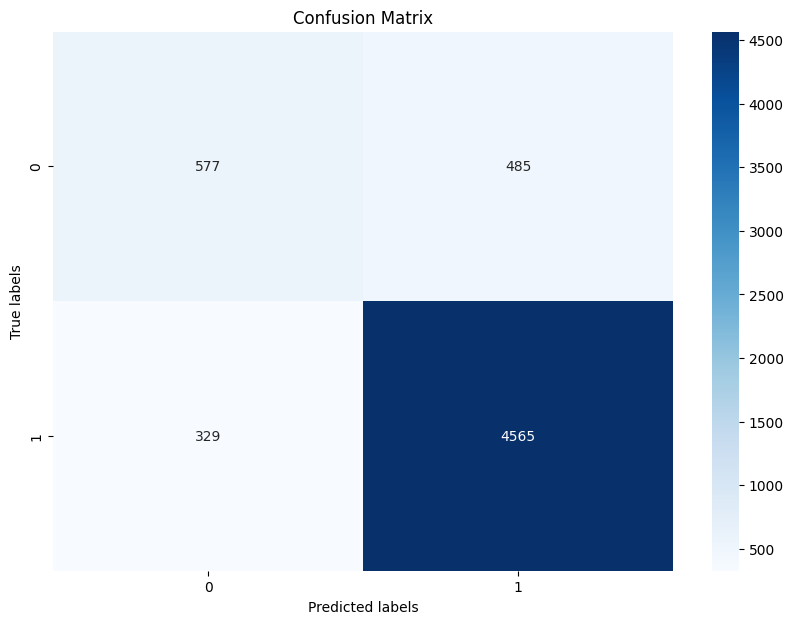

In [148]:
if torch.cuda.is_available():
    model = model.to('cuda')
predictions = predict_with_model(model, test_data_loader)
print_statistics(y_test, predictions)